In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches as patches

In [2]:
X1 = [1,1,1,1,1,1,1,1,1,1]
X2 = [0,0,0,0,0,0,0,1,0,0]
X3 = [1,1,1,0,1,0,1,0,1,1]
X4 = [1,1,1,0,0,0,0,0,1,1]
X5 = [1,1,1,0,0,0,0,0,1,1]
X6 = [1,1,1,0,0,0,0,0,1,1]
X7 = [1,1,1,0,0,0,0,0,1,1]
X8 = [1,1,1,1,1,1,1,0,1,1]
X9 = [0,1,1,1,1,1,1,0,1,1]
X10 = [1,1,1,1,1,1,1,0,1,1]
data = np.array([X1,X2,X3,X4,X5,X6,X7,X8,X9,X10])

In [33]:
dataFilter = np.zeros((2,3,3))

In [42]:
dataFilter[0, :, :] = np.array([[[0, 1/4, 0], 
                                   [1/4, 1/4, 1/4], 
                                   [0, 1/4, 0]]])
dataFilter[1, :, :] = np.array([[[1,   1,  1], 
                                   [0,   0,  0], 
                                   [-1, -1, -1]]])
dataFilter.shape

(2, 3, 3)

In [45]:
#convolution
def conv(data, convFilter):
    # Check dimension shape
    if len(data.shape) != len(convFilter.shape) - 1: 
        print("Error: Number of dimensions in conv filter and image do not match.")  
        exit()
    # Check image channel
    if len(data.shape) > 2 or len(convFilter.shape) > 3: 
        if data.shape[-1] != convFilter.shape[-1]:
            print("Error: Number of channels in both image and filter must match.")
            sys.exit()
    # Check filter dimesion
    if convFilter.shape[1] != convFilter.shape[2]:
        print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')
        sys.exit()
    if convFilter.shape[1]%2==0: 
        print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')
        sys.exit()

    # An empty feature map to hold the output of convolving the filter(s) with the image.
    featureMaps = np.zeros((data.shape[0]-convFilter.shape[1]+1, 
                            data.shape[1]-convFilter.shape[1]+1, 
                            convFilter.shape[0]))
    # Convolving the image by the filter(s).
    for filterNum in range(convFilter.shape[0]):
        print("Filter ", filterNum + 1)
        # getting a filter from the bank.
        currFilter = convFilter[filterNum, :]
        if len(currFilter.shape) > 2:
            # Array holding the sum of all feature maps.
            convMap = conv_(data[:, :, 0], currFilter[:, :, 0]) 
            # Convolving each channel with the image and summing the results.
            for ch_num in range(1, currFilter.shape[-1]): 
                convMap = convMap + conv_(data[:, :, chNum], 
                                  currFilter[:, :, chNum])
                 # There is just a single channel in the filter.
        else: 
            convMap = conv_(data, currFilter)
            # Holding feature map with the current filter.
        featureMaps[:, :, filterNum] = convMap 
        # Returning all feature maps.
    return featureMaps 

def conv_(data, convFilter):
    filterSize = convFilter.shape[1]
    result = np.zeros((data.shape))
    #Looping through the image to apply the convolution operation.
    for r in np.uint16(np.arange(filterSize/2.0, 
                          data.shape[0]-filterSize/2.0+1)):
        for c in np.uint16(np.arange(filterSize/2.0, 
                                           data.shape[1]-filterSize/2.0+1)):
            currRegion = data[r-np.uint16(np.floor(filterSize/2.0)):r+np.uint16(np.ceil(filterSize/2.0)), 
                              c-np.uint16(np.floor(filterSize/2.0)):c+np.uint16(np.ceil(filterSize/2.0))]
            #Element-wise multipliplication between the current region and the filter.
            currResult = currRegion * convFilter
            #Summing the result of multiplication.
            convSum = np.sum(currResult) 
            #Saving the summation in the convolution layer feature map.
            result[r, c] = convSum 
            
    #Clipping the outliers of the result matrix.
    finalResult = result[np.uint16(filterSize/2.0):result.shape[0]-np.uint16(filterSize/2.0), 
                          np.uint16(filterSize/2.0):result.shape[1]-np.uint16(filterSize/2.0)]
    return finalResult

In [46]:
dataFeatureMap = conv(data, dataFilter)
dataFeatureMap.shape

Filter  1
Filter  2


(4, 4, 2)

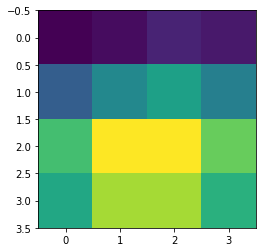

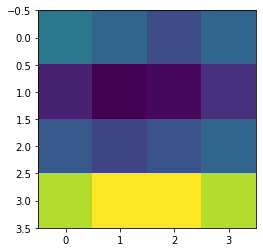

In [47]:
#relu activation function
for i in range(2):
    data = dataFeatureMap[:,:,i]
    plt.imshow(data) 
    plt.show()

In [48]:
def relu(featureMap):
    #Preparing the output of the ReLU activation function.
    reluOut = np.zeros(featureMap.shape)
    for mapNum in range(featureMap.shape[-1]):
        for r in np.arange(0,featureMap.shape[0]):
            for c in np.arange(0, featureMap.shape[1]):
                reluOut[r, c, mapNum] = np.max([featureMap[r, c, mapNum], 0])
    return reluOut

In [49]:
dataFeatureMap_relu = relu(dataFeatureMap)
dataFeatureMap_relu.shape

(4, 4, 2)

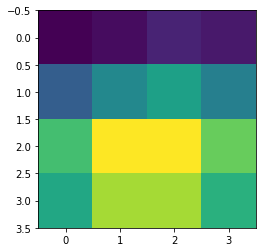

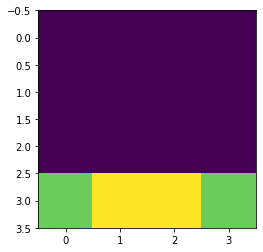

In [50]:
for i in range(2):
    data = dataFeatureMap_relu[:,:,i]
    plt.imshow(data) 
    plt.show()

In [59]:
#max pooling step
def pooling(featureMap, size=2, stride=2):
    #Preparing the output of the pooling operation.
    poolOut = np.zeros((np.uint16((featureMap.shape[0]-size+1)/stride+1),
                            np.uint16((featureMap.shape[1]-size+1)/stride+1),
                            featureMap.shape[-1]))
    for mapNum in range(featureMap.shape[-1]):
        r2 = 0
        for r in np.arange(0,featureMap.shape[0]-size+1, stride):
            c2 = 0
            for c in np.arange(0, featureMap.shape[1]-size+1, stride):
                poolOut[r2, c2, mapNum] = np.max([featureMap[r:r+size,  c:c+size, mapNum]])
                c2 = c2 + 1
            r2 = r2 +1
    return poolOut

In [60]:
dataFeatureMap_relu_pool = pooling(dataFeatureMap_relu, 2, 2) 
dataFeatureMap_relu_pool.shape

(2, 2, 2)

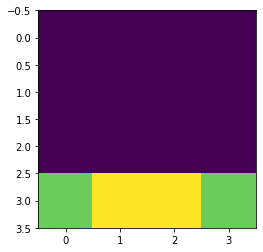

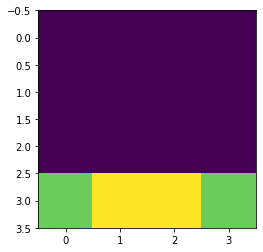

In [61]:
for i in range(2):
    img = dataFeatureMap_relu_pool[:,:,i]
    plt.imshow(data) 
    plt.show()